In [1]:
import pandas as pd
import json
from datetime import datetime
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = []
with open("../data/yelp_data/yelp_academic_dataset_business.json", "r", encoding = "UTF-8") as f:
    for line in f:
        data.append(json.loads(line))

df = json_normalize(data)

In [3]:
df.drop(['attributes.AcceptsInsurance', 'attributes.AgesAllowed','attributes.Alcohol', 'attributes.Ambience', 'attributes.BYOB', 
         'attributes.BYOBCorkage', 'attributes.BestNights', 'attributes.BikeParking','attributes.BusinessAcceptsBitcoin',
        'attributes.BusinessAcceptsCreditCards', 'attributes.BusinessParking','attributes.ByAppointmentOnly', 
         'attributes.Caters','attributes.CoatCheck', 'attributes.Corkage','attributes.DietaryRestrictions', 
         'attributes.DogsAllowed','attributes.DriveThru', 'attributes.GoodForDancing','attributes.GoodForKids', 
         'attributes.GoodForMeal','attributes.HairSpecializesIn', 'attributes.HappyHour','attributes.HasTV',
         'attributes.Music', 'attributes.NoiseLevel','attributes.Open24Hours', 'attributes.OutdoorSeating', 
         'attributes.RestaurantsAttire', 'attributes.RestaurantsCounterService','attributes.RestaurantsDelivery', 
         'attributes.RestaurantsGoodForGroups', 'attributes.RestaurantsPriceRange2', 'attributes.RestaurantsReservations',
         'attributes.RestaurantsTableService', 'attributes.RestaurantsTakeOut', 'attributes.Smoking',
         'attributes.WheelchairAccessible','attributes.WiFi','hours.Friday',
         'hours.Monday', 'hours.Saturday', 'hours.Sunday', 'hours.Thursday','hours.Tuesday', 'hours.Wednesday', 
         'is_open'], inplace = True, axis = 1)

In [4]:
lv_zip = [89044, 89054, 89101, 89102, 89103, 89104, 89106, 89107,
          89108, 89109, 89110, 89113, 89115, 89117, 89118, 89119, 89120, 
          89121, 89122, 89123, 89124, 89128, 89129, 89130, 89131, 89134, 
          89135, 89138, 89139, 89141, 89142, 89143, 89144, 89145, 89146, 89147, 
          89148, 89149, 89156, 89158, 89161, 89165, 89166, 89169, 89178, 89179, 89183, 89199]
lv_zip = [str(i) for i in lv_zip]
lv = df[df.postal_code.isin(lv_zip)]

In [5]:
lv_rest = pd.read_csv('../data/vegas_data.csv')
lv_rest.columns = [str.lower(i) for i in lv_rest.columns]

In [6]:
lv_rest.replace(regex = r'(?<=\d{5})-\d+', value = '', inplace = True)
lv_rest = lv_rest.dropna(subset = ['zip', 'address','restaurant name'])
lv_rest.loc[:,'address'] = lv_rest.apply(lambda row: str.lower(str(row['address'])).replace(' ', ''), axis = 1)
lv_rest.loc[:,'restaurant name']= lv_rest.apply(lambda row: str.lower(row['restaurant name']).replace(' ', ''), axis = 1)
lv.loc[:,'address'] = lv.apply(lambda row: str.lower(str(row['address'])).replace(' ', ''), axis = 1)
lv.loc[:,'name'] = lv.apply(lambda row: str.lower(row['name']).replace(' ', ''), axis = 1)

In [7]:
merged = lv_rest.merge(lv, left_on = ['address','restaurant name'] , right_on =['address','name'], how = 'left')

In [8]:
merged = merged[merged['name'].notnull()]
merged.drop(['attributes','hours'],inplace=True,axis=1)
merged.to_csv('vegas_yelp_business.csv', index = False)

In [9]:
rev = []
with open("../data/yelp_data/yelp_academic_dataset_review.json", "r", encoding = "UTF-8") as f:
    for line in f:
        rev.append(json.loads(line))

yelp_reviews = json_normalize(rev)

In [10]:
bus_id = merged.business_id.unique()
yelp_reviews = yelp_reviews[yelp_reviews.business_id.isin(bus_id)]

In [11]:
yelp_reviews.to_csv('vegas_yelp_reviews.csv', index = False)

In [13]:
review_data = pd.read_csv('vegas_yelp_reviews.csv')
business_data = pd.read_csv('vegas_yelp_business.csv')

print(review_data.shape)
print(business_data.shape)
business_data['inspection date'] = pd.to_datetime(business_data['inspection date'].apply(lambda x:str(x).split()[0]), 
                                                format='%m/%d/%Y')
business_data['inspection date'] = business_data['inspection date'].apply(lambda x:datetime(x.year,x.month,1))
review_data['date'] = pd.to_datetime(review_data['date'],format='%Y-%m-%d')
review_data['date'] = review_data['date'].apply(lambda x:datetime(x.year,x.month,1))
new_merged = business_data.merge(review_data, left_on = ['business_id','inspection date'] , right_on =['business_id','date'], how = 'left')
new_merged = new_merged[new_merged['inspection grade'].isin(['A', 'B', 'C'])]
# new_merged = new_merged.dropna()


def get_max_rows(df, gp, max_feat):
    B_maxes = df.groupby(gp)[max_feat].transform(max)
    return df[df[max_feat] == B_maxes] 

latest = get_max_rows(new_merged, ['business_id', 'inspection date'], 'inspection time')
final = get_max_rows(latest, ['business_id', 'inspection date'], 'review_id')

print(new_merged.shape)
print(latest.shape)
print(final.shape)

latest.rename(index=str, columns={"stars_x": "yelp_rating", "stars_y": "review_rating"},inplace=True)

final.rename(index=str, columns={"stars_x": "yelp_rating", "stars_y": "review_rating"},inplace=True)

# to check if new_merged.dropna() was needed. 
# for i in final.columns:
#     print(i,np.sum(final[i].isna()))
#on running this, it is clear that it was not needed.

(52816, 9)
(4015, 34)
(9829, 42)
(8158, 42)
(1662, 42)


In [23]:
#Code to extract aggregated ratings from all reviews. Takes a while to execute. ~2 mins
grouped = latest.groupby(['business_id', 'inspection date'])['review_rating'].mean()
final['avg_review_stars'] = 0
for i in final.iterrows():
    bus_id = i[1]['business_id']
    ins_date = i[1]['inspection date']
    mean=grouped.loc[(bus_id,ins_date)]
    final.loc[i[0],'avg_review_stars']=mean
    
#Code to extract aggregated useful ratings from all reviews. Takes a while to execute. ~2 mins
grouped = latest.groupby(['business_id', 'inspection date'])['useful'].mean()
final['avg_useful_review'] = 0
for i in final.iterrows():
    bus_id = i[1]['business_id']
    ins_date = i[1]['inspection date']
    mean=grouped.loc[(bus_id,ins_date)]
    final.loc[i[0],'avg_useful_review']=mean


KeyboardInterrupt: 

In [182]:
final['text'].unique()

array(["I normally enjoy coming to this location except when the heavy set mentally retarded cook is there. You have to repeat yourself at least 3 times and he still doesn't comprehend.  Very bad customer service, the cashier is friendly.",
       "The pizza is what you'd expect from a small pizza chain. Tastes very greasy and sort of flat but I still prefer it over large food chains like Pizza Hut and dominoes. Not my number one option for pizza in Vegas but definitely worth the try.",
       'I stop by here a few times every couple of months and have always liked the food and the portions are good sized for the price.  I started going once they added the vegan tofu "meat".  It is actually really, really good!  I have never had a complaint about service or anything and decided to do a review after my last visit on Wednesday night 12/14/16 because they were just exceptionally pleasant as they were taking our order.  Nothing specific to point out, they just had a great and happy energy 

In [47]:
drop_list = ['serial number', 'permit number', 'restaurant name', 'location name',
       'address', 'city_x', 'state_x','inspection date',
       'current demerits', 'current grade', 'date current',
       'inspection time', 'employee id', 
       'inspection result', 'record updated', 'location 1',
       'business_id', 'city_y',  'name',
    'review_id','postal_code',  'state_y','date', 
       'user_id','inspection demerits', 'permit status']

#set 1 to drop
check_list = {
    #Columns from inspection data
    'inspection type':0,
    'category name':0,
    'zip':0,
    'violations':1,
    
    #Columns from yelp data
    'neighborhood':1,
    'text':0,
    'categories':1,
    'latitude':0, 
    'longitude':0,
    'yelp_rating':0,
    'cool':1,#single review's cool rating
    'funny':1,#single review's funny rating
    'useful':1, #single review's useful rating
    'review_rating':1, # single review's star rating
#     'avg_useful_review':0, # combined reviews useful rating
#     'avg_review_stars':0,# combined reviews star rating
    'review_count':0
}
additional_drop_list = []
for key in check_list: 
    if check_list[key]==1:
        additional_drop_list.append(key)
first_model = final.drop(drop_list+additional_drop_list, axis = 1)
first_model['inspection grade'] = pd.factorize(first_model['inspection grade'])[0]
first_model.columns

Index(['category name', 'zip', 'inspection type', 'inspection grade',
       'latitude', 'longitude', 'review_count', 'yelp_rating', 'text',
       'avg_review_stars'],
      dtype='object')

In [48]:
first_model['inspection type'].unique()

array(['Routine Inspection', 'Re-inspection'], dtype=object)

In [49]:
#HANDLING CATEGORICAL FEATURES

#ONE HOT ENCODING

# from sklearn.preprocessing import OneHotEncoder
# temp = np.array(first_model['category name']).reshape(-1, 1)
# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(temp)
# enc.categories_
# ans = enc.transform(temp).toarray()
# first_model['test']=0
# ind=0
# for i in first_model.index:
#     first_model.loc[i,'test']=ans[ind]
#     ind+=1
#Have to concatenate features     
#np.concatenate((first_model, feature), axis=1)
# temp = pd.get_dummies(first_model,drop_first=True,prefix='dummy_')
# temp.columns

# data_used = temp #one hot encoded data

# FACTORIZING 

if 'inspection type' not in additional_drop_list:
    first_model['inspection type'] = pd.factorize(first_model['inspection type'])[0]
if 'category name' not in additional_drop_list:
    first_model['category name'] = pd.factorize(first_model['category name'])[0]
if 'neighborhood' not in additional_drop_list:
    first_model['neighborhood'] = pd.factorize(first_model['neighborhood'])[0]

data_used = first_model # factorized data

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

X = data_used
X=X.drop(['inspection grade'],axis=1)

Y = data_used['inspection grade']
x_train, x_test, y_train, y_test = train_test_split(data_used, data_used['inspection grade'], test_size=0.25, random_state=42)

In [51]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2018)
from gensim import corpora, models
def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [52]:
processed_docs = x_train['text'].map(preprocess)
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.75, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
x_train.loc[:,'topics'] = x_train.\
apply(lambda row: max(lda_model_tfidf[dictionary.doc2bow(preprocess(row['text']))],\
                      key = lambda item:item[1])[0], axis = 1)
x_test.loc[:,'topics'] = x_test.\
apply(lambda row: max(lda_model_tfidf[dictionary.doc2bow(preprocess(row['text']))],\
                      key = lambda item:item[1])[0], axis = 1)


In [53]:
x_train.drop(columns=['text'],axis=1,inplace=True)
x_test.drop(columns=['text'],axis=1,inplace=True)
x_train.columns

Index(['category name', 'zip', 'inspection type', 'inspection grade',
       'latitude', 'longitude', 'review_count', 'yelp_rating',
       'avg_review_stars', 'topics'],
      dtype='object')

Training Data Counts
0    1102
2      82
1      62
Name: inspection grade, dtype: int64
Balanced Training Data Counts
1    1102
2    1102
0    1102
Name: inspection grade, dtype: int64
Testing Data Counts
0    361
2     32
1     23
Name: inspection grade, dtype: int64
Balanced Testing Data Counts
2    23
1    23
0    23
Name: inspection grade, dtype: int64
0.36231884057971014
[[21 18 19]
 [ 2  2  2]
 [ 0  3  2]]


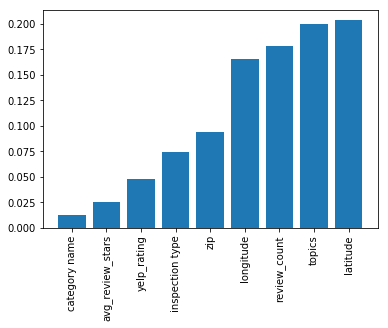

,feature_importance
category name,0.012254
avg_review_stars,0.024857
yelp_rating,0.048075
inspection type,0.074580
zip,0.093689
longitude,0.165232
review_count,0.178646
topics,0.199396
latitude,0.203272


In [54]:
print('Training Data Counts')
print(x_train['inspection grade'].value_counts())
max_cnt = x_train['inspection grade'].value_counts()[0]
# max_cnt=150
major_1 = x_train[x_train['inspection grade'] == 0]
minority_1= x_train[x_train['inspection grade'] == 1]
minority_2 = x_train[x_train['inspection grade'] == 2]

maj_down = resample(major_1, replace=False, n_samples=max_cnt, random_state=122)
min1_up = resample(minority_1, replace=True, n_samples=max_cnt, random_state=123)
min2_up = resample(minority_2, replace=True, n_samples=max_cnt, random_state=124)
x_train = pd.concat([maj_down, min1_up, min2_up])
y_train = x_train['inspection grade']


print('Balanced Training Data Counts')
print(x_train['inspection grade'].value_counts())

print('Testing Data Counts')
print(x_test['inspection grade'].value_counts())
min_cnt = x_test['inspection grade'].value_counts()[1]
major_1 = x_test[x_test['inspection grade'] == 0]
minority_1= x_test[x_test['inspection grade'] == 1]
minority_2 = x_test[x_test['inspection grade'] == 2]

maj_down = resample(major_1, replace=False, n_samples=min_cnt, random_state=122)
min1_down = resample(minority_1, replace=False, n_samples=min_cnt, random_state=123)
min2_down = resample(minority_2, replace=False, n_samples=min_cnt, random_state=124)
x_test = pd.concat([maj_down, min1_down, min2_down])
y_test = x_test['inspection grade']


print('Balanced Testing Data Counts')
print(y_test.value_counts())

x_train = x_train.drop(['inspection grade'],axis=1)
x_test = x_test.drop(['inspection grade'],axis=1)

# clf = LogisticRegression()

# clf = RandomForestClassifier(n_estimators = 50,criterion = 'entropy')
clf = DecisionTreeClassifier(criterion = 'entropy')
clf = clf.fit(x_train, y_train)
preds = clf.predict(x_test)
print(accuracy_score(preds,y_test))
print(confusion_matrix(preds,y_test))

feat_dict = dict(zip(x_train.columns,clf.feature_importances_))
features = pd.DataFrame(pd.Series(feat_dict),columns=['feature_importance'])
sortd= features.sort_values(by=['feature_importance'])

plt.bar(range(len(sortd)), sortd['feature_importance'], align='center')
plt.xticks(range(len(sortd)), sortd.index,rotation = 'vertical')

plt.show()
sortd

In [180]:
##CROSS VALIDATION

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

kfolds = KFold(n_splits = 4)

steps = [('scaler', StandardScaler()),
         ('dt', DecisionTreeClassifier())]

pipeline = Pipeline(steps)

parameters_scaler = dict(dt__criterion = ['gini','entropy'],
                  dt__splitter = ['best', 'random'],
#                     dt__n_estimators = [10,50,100,200],
                        dt__min_samples_leaf = [5,10,20],
                        dt__min_samples_split = [4,5,10],
                        dt__class_weight = ['balanced',None])

dt_grid_search_scaler = GridSearchCV(pipeline, param_grid = parameters_scaler, cv = kfolds, scoring = 'accuracy')

dt_grid_search_scaler.fit(x_train, y_train)
print(dt_grid_search_scaler.best_estimator_.steps[-1][1])
print(dt_grid_search_scaler.best_score_)
preds = dt_grid_search_scaler.predict(x_test)
print(accuracy_score(preds,y_test))
print(confusion_matrix(preds,y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.5933333333333334
0.4057971014492754
[[12 10 10]
 [ 8  5  2]
 [ 3  8 11]]
